# Import packages


In [1]:
import numpy as np
import pylab as pl
from numpy import fft
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
from dateutil.relativedelta import relativedelta
import math
import matplotlib.dates as mdates
import warnings

# Load data


In [2]:
def load_data(stock_name, date_predict_start, data_range, slide_range, n_slide):
    train_data = {}
    test_data = {}
    date_predict_start = datetime.datetime.strptime(
        date_predict_start, '%Y-%m-%d').date()
    date_data_start_list = []
    date_predict_start_list = []
    date_predict_end_list = []
    test_data_start_list = []
    all_data = yf.Ticker(stock_name).history(period='max')
    all_data.index = all_data.index.date
    check = date_predict_start in all_data.index
    while (check == False):
        date_predict_start = date_predict_start + \
            relativedelta(days=+1)
        check = date_predict_start in list(all_data.index)
    predict_start = all_data.index.get_loc(date_predict_start)
    for i in range(n_slide):
        predict_end = predict_start + data_range
        print(predict_start, predict_end)
        date_predict_end = all_data.iloc[predict_end].name
        data_start = predict_start - data_range
        date_data_start = all_data.iloc[data_start].name
        train_data['data_' + str(i)] = all_data.iloc[data_start:predict_start]
        test_data['data_' + str(i)] = all_data.iloc[predict_start:predict_end]
        date_data_start_list.append(date_data_start)
        date_predict_start_list.append(date_predict_start)
        date_predict_end_list.append(date_predict_end)
        test_data_start_list.append(test_data['data_' + str(i)].index[0])
        data_start = data_start + slide_range
        predict_start = predict_start + slide_range
        train_data['data_' + str(i)] = train_data['data_' +
                                                  str(i)].reset_index(drop=False)
        test_data['data_' + str(i)] = test_data['data_' +
                                                str(i)].reset_index(drop=False)

    return train_data, test_data, all_data, test_data_start_list


In [3]:
stock_name = "^GSPC"
date_predict_start = '2020-01-01'
data_range = 250
slide_range = 10
n_slide = 10
pv_range = 2
n_harm_lower_limit = 1
n_harm_upper_limit = 50
fit_method = 'rmse'
pv_method = 'CL'

In [4]:
train_data, test_data, all_data, test_data_start_list = load_data(stock_name, date_predict_start, data_range, slide_range, n_slide)

23109 23359
23119 23369
23129 23379
23139 23389
23149 23399
23159 23409
23169 23419
23179 23429
23189 23439
23199 23449


In [5]:
all_data.iloc[23449]

Open            4.228290e+03
High            4.236390e+03
Low             4.188130e+03
Close           4.188430e+03
Volume          4.560700e+09
Dividends       0.000000e+00
Stock Splits    0.000000e+00
Name: 2021-05-10, dtype: float64

In [6]:
test_data['data_9']

,index,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2020-05-12,2939.500000,2945.820068,2869.590088,2870.120117,5119630000,0.0,0.0
1,2020-05-13,2865.860107,2874.139893,2793.149902,2820.000000,6151650000,0.0,0.0
2,2020-05-14,2794.540039,2852.800049,2766.639893,2852.500000,5651130000,0.0,0.0
3,2020-05-15,2829.949951,2865.010010,2816.780029,2863.699951,5507700000,0.0,0.0
4,2020-05-18,2913.860107,2968.090088,2913.860107,2953.909912,6373670000,0.0,0.0
...,...,...,...,...,...,...,...,...
245,2021-05-03,4191.979980,4209.390137,4188.029785,4192.660156,4070220000,0.0,0.0
246,2021-05-04,4179.040039,4179.040039,4128.589844,4164.660156,4452460000,0.0,0.0
247,2021-05-05,4177.060059,4187.720215,4160.939941,4167.589844,4230920000,0.0,0.0
248,2021-05-06,4169.140137,4202.700195,4147.330078,4201.620117,4511000000,0.0,0.0


# Data preprocessing


In [7]:
def find_data_pv_CL_function(data, pv_range):
    pd.options.mode.chained_assignment = None
    for i in data:
        price = data[i]['Close']
        data[i]['peaks'] = pd.Series(dtype='float64')
        data[i]['valleys'] = pd.Series(dtype='float64')
        data[i]['pv'] = pd.Series(dtype='str')
        for idx in range(0, len(price)):
            if idx < pv_range:
                if price[idx] == price.iloc[0:pv_range*2+1].max():
                    data[i]['peaks'].iloc[idx] = price[idx]
                    data[i]['pv'].iloc[idx] = 'peak'
                if price[idx] == price.iloc[0:pv_range*2+1].min():
                    data[i]['valleys'].iloc[idx] = price[idx]
                    data[i]['pv'].iloc[idx] = 'valley'
            if price[idx] == price.iloc[idx-pv_range:idx+pv_range].max():
                data[i]['peaks'].iloc[idx] = price[idx]
                data[i]['pv'].iloc[idx] = 'peak'
            if price[idx] == price.iloc[idx-pv_range:idx+pv_range].min():
                data[i]['valleys'].iloc[idx] = price[idx]
                data[i]['pv'].iloc[idx] = 'valley'


In [8]:
def find_data_pv_HL_function(data, pv_range):
    pd.options.mode.chained_assignment = None
    for i in data:
        high = data[i]['High']
        low = data[i]['Low']
        data[i]['peaks'] = pd.Series(dtype='float64')
        data[i]['valleys'] = pd.Series(dtype='float64')
        data[i]['pv'] = pd.Series(dtype='str')
        for idx in range(0, len(high)):
            if idx < pv_range and idx>0:
                if high[idx] == high.iloc[0:pv_range*2+1].max():
                    data[i]['peaks'].iloc[idx] = high[idx]
                    data[i]['pv'].iloc[idx] = 'peak'
                if low[idx] == low.iloc[0:pv_range*2+1].min():
                    data[i]['valleys'].iloc[idx] = low[idx]
                    data[i]['pv'].iloc[idx] = 'valley'
            if high[idx] == high.iloc[idx-pv_range:idx+pv_range].max():
                data[i]['peaks'].iloc[idx] = high[idx]
                data[i]['pv'].iloc[idx] = 'peak'
            if low[idx] == low.iloc[idx-pv_range:idx+pv_range].min():
                data[i]['valleys'].iloc[idx] = low[idx]
                data[i]['pv'].iloc[idx] = 'valley'


In [9]:
def preprocessing(train_data, test_data, pv_range, pv_method):
    if pv_method == 'CL':
        find_data_pv_CL_function(train_data, pv_range)
        find_data_pv_CL_function(test_data, pv_range)
    elif pv_method == 'HL':
        find_data_pv_HL_function(train_data, pv_range)
        find_data_pv_HL_function(test_data, pv_range)
    else :
        print('worng pv_method')


# Built Model


Get signal


In [10]:
def data_to_harmonics_function(data_stock, data_range):
    harmonics = {}
    for i in data_stock:
        harmonics[i] = {}
        # get data_stock's infomation
        data = data_stock[i]['Close']
        array_data = np.array(data)
        n_data = array_data.size
        time_data = np.arange(0, n_data)

        # detrend data
        # find linear trend in data
        Polynomial = np.polyfit(time_data, array_data, 1)
        data_notrend = array_data - Polynomial[0] * time_data    # detrended x

        # fft process
        data_freqdom = fft.fft(data_notrend, n=n_data)
        frequence = fft.fftfreq(n=n_data, d=1)
        f_positive = frequence[np.where(frequence > 0)]
        data_freqdom_positive = data_freqdom[np.where(frequence > 0)]

        # sort indexes
        indexes = list(range(f_positive.size))      # frequencies
        # sort method 1
        # indexes.sort(key = lambda i: np.absolute(frequence[i]))     # sort indexes by frequency, lower -> higher
        # sort method 2 :
        # sort indexes by amplitudes, lower -> higher
        indexes.sort(key=lambda i: np.absolute(data_freqdom[i]))
        indexes.reverse()       # sort indexes by amplitudes, higher -> lower

        # get data_all_time'size
        time_transfer = np.arange(0, data_range*2)

        # get harmonics
        for j in indexes:
            ampli = np.absolute(
                data_freqdom_positive[j]) / n_data     # amplitude
            phase = np.angle(data_freqdom_positive[j])      # phase
            harmonics[i][j] = ampli * \
                np.cos(2 * np.pi * f_positive[j] * time_transfer + phase)
    return harmonics


In [11]:
def mix_harmonics_function(harmonics, n_harm_lower_limit, n_harm_upper_limit):
    processed_signal = {}
    for i in harmonics:
        processed_signal[i] = {}
        for n_harm in range(n_harm_lower_limit, n_harm_upper_limit+1):
            mixed_harmonic = np.zeros(len(harmonics[i][0]))
            # for j in range(n_harm):
            for j in range(2, n_harm):
                mixed_harmonic += harmonics[i][j]
            processed_signal[i][n_harm] = pd.DataFrame(
                {'Close': mixed_harmonic})
    return processed_signal


Signal processing


In [12]:
def find_signal_pv_function(signal, pv_range):
    pd.options.mode.chained_assignment = None
    for i in signal:
        for j in signal[i]:
            data = signal[i][j]['Close']
            signal[i][j]['peaks'] = pd.Series(dtype='float64')
            signal[i][j]['valleys'] = pd.Series(dtype='float64')
            signal[i][j]['pv'] = pd.Series(dtype='str')
            for idx in range(0, len(data)):
                if idx < pv_range and idx>0:
                    if data[idx] == data.iloc[0:pv_range*2+1].max():
                        signal[i][j]['peaks'].iloc[idx] = data[idx]
                        signal[i][j]['pv'].iloc[idx] = 'peak'
                    if data[idx] == data.iloc[0:pv_range*2+1].min():
                        signal[i][j]['valleys'].iloc[idx] = data[idx]
                        signal[i][j]['pv'].iloc[idx] = 'valley'
                if data[idx] == data.iloc[idx-pv_range:idx+pv_range].max():
                    signal[i][j]['peaks'].iloc[idx] = data[idx]
                    signal[i][j]['pv'].iloc[idx] = 'peak'
                if data[idx] == data.iloc[idx-pv_range:idx+pv_range].min():
                    signal[i][j]['valleys'].iloc[idx] = data[idx]
                    signal[i][j]['pv'].iloc[idx] = 'valley'


In [13]:
def find_signal_lead_train_function(data, processed_signal):
    for d in data:
        for p in processed_signal[d]:
            # processed_signal[d][p]['pv'] = pd.Series(dtype='str')
            processing_signal = processed_signal[d][p].head(len(data[d]))
            p_data = pd.DataFrame(
                {'peaks': data[d]['peaks'], 'count': range(len(data[d]))})
            p_data = p_data.drop(p_data[p_data['peaks'].isna()].index)
            p_data_count = list(p_data['count'])
            p_signal = pd.DataFrame(
                {'peaks': processing_signal['peaks'], 'count': range(len(processing_signal))})
            p_signal = p_signal.drop(p_signal[p_signal['peaks'].isna()].index)
            p_signal_list = list(p_signal['count'])
            p_lead = []
            for i in range(0, len(p_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(p_data_count)):
                    temp.append((p_data_count[j] - p_signal_list[i]))
                    temp_abs.append(abs(p_data_count[j] - p_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                p_lead.append(temp_2)
            p_signal['lead'] = p_lead

            v_data = pd.DataFrame(
                {'valleys': data[d]['valleys'], 'count': range(len(data[d]))})
            v_data = v_data.drop(v_data[v_data['valleys'].isna()].index)
            v_data_count = list(v_data['count'])
            v_signal = pd.DataFrame(
                {'valleys': processing_signal['valleys'], 'count': range(len(processing_signal))})
            v_signal = v_signal.drop(
                v_signal[v_signal['valleys'].isna()].index)
            v_signal_list = list(v_signal['count'])
            v_lead = []
            for i in range(0, len(v_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(v_data_count)):
                    temp.append((v_data_count[j] - v_signal_list[i]))
                    temp_abs.append(abs(v_data_count[j] - v_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                v_lead.append(temp_2)
            v_signal['lead'] = v_lead

            processed_signal[d][p]['lead'] = pd.Series(dtype='float64')
            processed_signal[d][p]['lead'].loc[p_signal['lead'].index] = p_signal['lead']
            processed_signal[d][p]['lead'].loc[v_signal['lead'].index] = v_signal['lead']


In [14]:
def build_model(train_data, n_harm_lower_limit, n_harm_upper_limit, pv_range, data_range):
    harmonics = data_to_harmonics_function(train_data, data_range)
    processed_signal = mix_harmonics_function(
        harmonics, n_harm_lower_limit, n_harm_upper_limit)
    find_signal_pv_function(processed_signal, pv_range)
    find_signal_lead_train_function(train_data, processed_signal)
    return harmonics, processed_signal


# Select model


In [15]:
def get_fit_error_function(processed_signal, fit_method):
    errors = {}
    error = []
    for i in processed_signal:
        errors[i] = {}
        for j in processed_signal[i]:
            signal_dropna = processed_signal[i][j].drop(
                processed_signal[i][j][processed_signal[i][j]['lead'].isna()].index)
            if fit_method == 'mean':
                error = signal_dropna['lead'].mean()
            elif fit_method == 'abs':
                error = abs(signal_dropna['lead']).mean()
            elif fit_method == 'rmse':
                mse = np.square(np.subtract(np.zeros_like(
                    signal_dropna['lead']), signal_dropna['lead'])).mean()
                rmse = math.sqrt(mse)
                error = rmse
            else :
                print('worng fit_method')
            errors[i][j] = error
    return errors


In [16]:
def get_best_fit_harm_function(processed_signal, errors):
    best_error = {}
    best_fit_harm = {}
    for i in processed_signal:
        best_error[i] = pd.Series(errors[i]).abs().min()
        best_fit_harm[i] = pd.Series(errors[i]).abs().idxmin()
    return best_fit_harm, best_error


In [17]:
def find_signal_lead_test_function(data, processed_signal):
    for d in data:
        for p in processed_signal[d]:
            processed_signal[d][p]['pv'] = pd.Series(dtype='str')
            processing_signal = processed_signal[d][p].tail(len(data[d]))
            p_data = pd.DataFrame(
                {'peaks': data[d]['peaks'], 'count': range(len(data[d]))})
            p_data = p_data.drop(p_data[p_data['peaks'].isna()].index)
            p_data_count = list(p_data['count'])
            p_signal = pd.DataFrame(
                {'peaks': processing_signal['peaks'], 'count': range(len(processing_signal))})
            p_signal = p_signal.drop(p_signal[p_signal['peaks'].isna()].index)
            p_signal_list = list(p_signal['count'])
            p_lead = []
            for i in range(0, len(p_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(p_data_count)):
                    temp.append((p_data_count[j] - p_signal_list[i]))
                    temp_abs.append(abs(p_data_count[j] - p_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                p_lead.append(temp_2)
            p_signal['lead'] = p_lead

            v_data = pd.DataFrame(
                {'valleys': data[d]['valleys'], 'count': range(len(data[d]))})
            v_data = v_data.drop(v_data[v_data['valleys'].isna()].index)
            v_data_count = list(v_data['count'])
            v_signal = pd.DataFrame(
                {'valleys': processing_signal['valleys'], 'count': range(len(processing_signal))})
            v_signal = v_signal.drop(
                v_signal[v_signal['valleys'].isna()].index)
            v_signal_list = list(v_signal['count'])
            v_lead = []
            for i in range(0, len(v_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(v_data_count)):
                    temp.append((v_data_count[j] - v_signal_list[i]))
                    temp_abs.append(abs(v_data_count[j] - v_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                v_lead.append(temp_2)
            v_signal['lead'] = v_lead

            processed_signal[d][p]['lead'] = pd.Series(dtype='float64')
            processed_signal[d][p]['lead'].loc[p_signal['lead'].index] = p_signal['lead']
            processed_signal[d][p]['pv'].loc[p_signal['lead'].index] = 'peak'
            processed_signal[d][p]['lead'].loc[v_signal['lead'].index] = v_signal['lead']
            processed_signal[d][p]['pv'].loc[v_signal['lead'].index] = 'valley'


In [18]:
def get_first_lead_function(processed_signal, best_fit_harm):
    first_date = {}
    lead = {}
    pv = {}
    for i in processed_signal:
        harm = best_fit_harm[i]
        temp = processed_signal[i][harm].loc[list(
            processed_signal[i][harm]['lead'].dropna().index)[0]]
        first_date[i] = list(processed_signal[i][harm]
                             ['lead'].dropna().index)[0]
        lead[i] = temp['lead']
        pv[i] = temp['pv']
    return first_date, lead, pv


In [19]:
def select_model(test_data, processed_signal, fit_method):
    errors = get_fit_error_function(processed_signal, fit_method)
    best_fit_harm, best_error = get_best_fit_harm_function(
        processed_signal, errors)
    find_signal_lead_test_function(test_data, processed_signal)
    first_date, lead, pv = get_first_lead_function(
        processed_signal, best_fit_harm)
    return errors, best_fit_harm, best_error, first_date, lead, pv


# Evaluate model


In [20]:
def built_result_table_function(processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm):
    result_table = pd.DataFrame(columns=[
        's_date', 't_date', 'lead', 'ans_date', 'pv', 'error', 'best_fit'])
    for i in processed_signal:
        result_table.loc[i, 'error'] = round(best_error[i], 2)
        result_table.loc[i, 'best_fit'] = best_fit_harm[i]
        result_table.loc[i, 'lead'] = lead[i]
        result_table.loc[i, 'pv'] = pv[i]
    result_table['s_date'] = test_data_start_list
    return result_table


In [21]:
def result_table_process_function(result_table, all_data, first_date, data_range):
    for i in result_table.index:
        t_date = all_data.iloc[all_data.index.get_loc(result_table.loc[i, 's_date']) + first_date[i] - data_range].name
        result_table.loc[i, 't_date'] = t_date
        ans = all_data.iloc[int(all_data.index.get_loc(t_date) + result_table.loc[i, 'lead'])].name
        result_table.loc[i, 'ans_date'] = ans

In [22]:
def compute_final_error_function(result_table):
    final_error = round(
        sum([abs(ele) for ele in result_table['lead']]) / len(result_table['lead']), 2)
    return final_error


In [23]:
def evaluate_model(processed_signal, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range):
    result_table = built_result_table_function(
        processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm)
    result_table_process_function(
        result_table, all_data, first_date, data_range)
    final_error = compute_final_error_function(result_table)
    return result_table, final_error


# Draw plot


In [24]:
def find_data_pv_function(data, pv_range):
    pd.options.mode.chained_assignment = None
    price = data['Close']
    data['peaks'] = pd.Series(dtype='float64')
    data['valleys'] = pd.Series(dtype='float64')
    data['pv'] = pd.Series(dtype='str')
    for idx in range(0, len(price)):
        if idx < pv_range and idx>0:
            if price[idx] == price.iloc[0:pv_range*2+1].max():
                data['peaks'].iloc[idx] = price[idx]
                data['pv'].iloc[idx] = 'peak'
            if price[idx] == price.iloc[0:pv_range*2+1].min():
                data['valleys'].iloc[idx] = price[idx]
                data['pv'].iloc[idx] = 'valleys'
        if price[idx] == price.iloc[idx-pv_range:idx+pv_range].max():
            data['peaks'].iloc[idx] = price[idx]
            data['pv'].iloc[idx] = 'peak'
        if price[idx] == price.iloc[idx-pv_range:idx+pv_range].min():
            data['valleys'].iloc[idx] = price[idx]
            data['pv'].iloc[idx] = 'valleys'


In [25]:
def draw_plot_result_table(test_data, all_data, result_table, pv_range):
    date_list = sorted(
        list(result_table['s_date']) + list(result_table['t_date']) + list(result_table['ans_date']))
    all_index = all_data.loc[date_list[0]:date_list[-1]].index
    fig, axes = plt.subplots(2, 1, figsize=(30, 8), sharex=True)
    test_data_copy = test_data.copy()
    for d in test_data :
        test_data_copy[d].index = test_data[d]['index']
        test_data_copy[d] = test_data_copy[d].drop(test_data_copy[d][test_data_copy[d].index > date_list[-1]].index)
        axes[0].plot(test_data_copy[d].index, test_data_copy[d]['Close'], 'gray', label='data', linewidth=3)
    for d in test_data_copy :
        axes[0].plot(test_data_copy[d].index, test_data_copy[d]['peaks'],
                    '^', c='royalblue', label='peaks')
        axes[0].plot(test_data_copy[d].index, test_data_copy[d]['valleys'], 'v',
                    c='orangered', label='valleys')
    plot_model = pd.DataFrame(index=all_index, columns=[
                                's_date', 't_date', 'ans_date', 'lead', 'pv'])
    plot_model['s_date'].loc[result_table['s_date']] = True
    plot_model['t_date'].loc[result_table['t_date']] = True
    plot_model['lead'].loc[result_table['t_date']] = list(result_table['lead'])
    plot_model['pv'].loc[result_table['t_date']] = list(result_table['pv'])
    plot_model['ans_date'].loc[result_table['ans_date']] = True
    for i, label in enumerate(plot_model['lead']):
        if plot_model['pv'][i] == 'peak':
            # axes[0].plot(plot_data.index[i], plot_data['Close'].iloc[i], '|',
            #             c='red')
            axes[1].plot(plot_model.index[i], plot_model['lead'][i], '^',
                            c='royalblue')
            text = str(label)
            axes[1].annotate(text, (plot_model.index[i],
                                plot_model['lead'][i]), fontsize=14)
        elif plot_model['pv'][i] == 'valley':
            # axes[0].plot(plot_data.index[i], plot_data['Close'].iloc[i], '|',
            #             c='red')
            axes[1].plot(plot_model.index[i], plot_model['lead'][i], 'v',
                            c='orangered')
            text = str(label)
            axes[1].annotate(text, (plot_model.index[i],
                                plot_model['lead'][i]), fontsize=14)

    axes[0].set_ylabel("Stock price", fontsize=14)
    axes[0].grid(True)
    axes[1].grid(True)
    axes[1].set_ylabel("lead", fontsize=14)
    plt.show()

# Main function


In [26]:
def main_funtion(
    stock_name, date_predict_start, data_range, slide_range,
        n_slide, pv_range, n_harm_lower_limit, n_harm_upper_limit, fit_method, pv_method):

    # 1. Load data
    train_data, test_data, all_data, test_data_start_list = load_data(
        stock_name, date_predict_start, data_range, slide_range, n_slide)
    # 2. Preprocessing
    preprocessing(train_data, test_data, pv_range, pv_method)
    # 3. Build model
    harmonics, model = build_model(
        train_data, n_harm_lower_limit, n_harm_upper_limit, pv_range, data_range)
    # 4. Select model
    errors, best_fit_harm, best_error, first_date, lead, pv = select_model(test_data,
                                                                           model, fit_method)
    # 5. Evaluate model
    result_table, final_error = evaluate_model(
        model, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range)
    print('final_error = ', final_error)
    with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
        print(result_table)
    draw_plot_result_table(test_data, all_data, result_table, pv_range)
    # return harmonics, model, errors, best_fit_harm, best_error, first_date, lead, pv, result_table, final_error


In [27]:
stock_name = "^GSPC"
date_predict_start = '2020-01-01'
data_range = 250
slide_range = 10
n_slide = 10
pv_range = 5
n_harm_lower_limit = 1
n_harm_upper_limit = 50
fit_method = 'rmse'
pv_method = 'CL'

In [28]:
# main_funtion(
#     stock_name, date_predict_start, data_range, slide_range,
#         n_slide, pv_range, n_harm_lower_limit, n_harm_upper_limit, fit_method, pv_method)

In [29]:
# 1. Load data
train_data, test_data, all_data, test_data_start_list = load_data(
    stock_name, date_predict_start, data_range, slide_range, n_slide)
# 2. Preprocessing
preprocessing(train_data, test_data, pv_range, pv_method)


23109 23359
23119 23369
23129 23379
23139 23389
23149 23399
23159 23409
23169 23419
23179 23429
23189 23439
23199 23449


In [30]:
test_data['data_9']

,index,Open,High,Low,Close,Volume,Dividends,Stock Splits,peaks,valleys,pv
0,2020-05-12,2939.500000,2945.820068,2869.590088,2870.120117,5119630000,0.0,0.0,NaN,NaN,NaN
1,2020-05-13,2865.860107,2874.139893,2793.149902,2820.000000,6151650000,0.0,0.0,NaN,2820.000000,valley
2,2020-05-14,2794.540039,2852.800049,2766.639893,2852.500000,5651130000,0.0,0.0,NaN,NaN,NaN
3,2020-05-15,2829.949951,2865.010010,2816.780029,2863.699951,5507700000,0.0,0.0,NaN,NaN,NaN
4,2020-05-18,2913.860107,2968.090088,2913.860107,2953.909912,6373670000,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
245,2021-05-03,4191.979980,4209.390137,4188.029785,4192.660156,4070220000,0.0,0.0,NaN,NaN,NaN
246,2021-05-04,4179.040039,4179.040039,4128.589844,4164.660156,4452460000,0.0,0.0,NaN,4164.660156,valley
247,2021-05-05,4177.060059,4187.720215,4160.939941,4167.589844,4230920000,0.0,0.0,NaN,NaN,NaN
248,2021-05-06,4169.140137,4202.700195,4147.330078,4201.620117,4511000000,0.0,0.0,NaN,NaN,NaN


In [31]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.random import shuffle

In [32]:
def preprocessing_train_data_Lstm(train_data, base_day, prediction_day, slide):
    x_train = {}
    y_train = {}
    for i in train_data:
        scaler = MinMaxScaler(feature_range=(-1,1))
        scaled_data = scaler.fit_transform(train_data[i]['Close'].values.reshape(-1,1))
        x_train[i] = []
        y_train[i] = []
        for x in range(base_day+prediction_day, len(scaled_data), slide):
            x_train[i].append(scaled_data[x-base_day-prediction_day:x-prediction_day])
            y_train[i].append(scaled_data[x-prediction_day:x])
        x_train[i], y_train[i] = np.array(x_train[i]), np.array(y_train[i])
        # 將x_train數組的形狀轉換為（樣本數，天數，特徵數）的形式，這裡的特徵數為1
        x_train[i] = np.reshape(x_train[i], (x_train[i].shape[0], x_train[i].shape[1], 1))
        y_train[i] = np.reshape(y_train[i], (y_train[i].shape[0], y_train[i].shape[1], 1))
    return x_train, y_train

In [33]:
base_day = 10
prediction_day = base_day
slide = base_day

In [34]:
x_train, y_train = preprocessing_train_data_Lstm(train_data, base_day, prediction_day, slide)

In [35]:
def LSTM_model(prediction_day, input_shape):
    model = Sequential()
    model.add(LSTM(units = 256, return_sequences = True, input_shape = input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 128, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 64))
    model.add(Dropout(0.2))
    model.add(Dense(units=prediction_day))
    return model

In [36]:
input_shape = (x_train[list(x_train.keys())[0]].shape[1],1)

In [37]:
def build_Lstm_model(prediction_day, input_shape):
    model = {}
    for i in train_data:
        model[i] = LSTM_model(prediction_day, input_shape)
        model[i].compile(optimizer='adam', 
                    loss='mean_squared_error')
        # model[i].summary()
    return model

In [38]:
model = build_Lstm_model(prediction_day, input_shape)

In [39]:
from tqdm import tqdm

In [40]:
def train_Lstm_model():
    history = {}
    for i in tqdm(train_data):
        earlystopper = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 2)
        history[i] = model[i].fit(x_train[i], y_train[i], epochs=25, batch_size=32, 
                            callbacks = [earlystopper], validation_split = 0.2, shuffle=True)
    return history

In [41]:
history = train_Lstm_model()

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/25
1/1 [==============================] - 6s 6s/step - loss: 0.0724 - val_loss: 0.2945
Epoch 2/25
1/1 [==============================] - 0s 84ms/step - loss: 0.0668 - val_loss: 0.2811
Epoch 3/25
1/1 [==============================] - 0s 72ms/step - loss: 0.0610 - val_loss: 0.2638
Epoch 4/25
1/1 [==============================] - 0s 67ms/step - loss: 0.0542 - val_loss: 0.2415
Epoch 5/25
1/1 [==============================] - 0s 73ms/step - loss: 0.0465 - val_loss: 0.2107
Epoch 6/25
1/1 [==============================] - 0s 74ms/step - loss: 0.0394 - val_loss: 0.1721
Epoch 7/25
1/1 [==============================] - 0s 72ms/step - loss: 0.0326 - val_loss: 0.1338
Epoch 8/25
1/1 [==============================] - 0s 74ms/step - loss: 0.0317 - val_loss: 0.1061
Epoch 9/25
1/1 [==============================] - 0s 75ms/step - loss: 0.0325 - val_loss: 0.0897
Epoch 10/25
1/1 [==============================] - 0s 75ms/step - loss: 0.0276 - val_loss: 0.0837
Epoch 11/25
1/1 [==============

 10%|█         | 1/10 [00:07<01:05,  7.27s/it]

Epoch 1/25
1/1 [==============================] - 6s 6s/step - loss: 0.1024 - val_loss: 0.2673
Epoch 2/25
1/1 [==============================] - 0s 77ms/step - loss: 0.0924 - val_loss: 0.2604
Epoch 3/25
1/1 [==============================] - 0s 64ms/step - loss: 0.0779 - val_loss: 0.2521
Epoch 4/25
1/1 [==============================] - 0s 71ms/step - loss: 0.0669 - val_loss: 0.2419
Epoch 5/25
1/1 [==============================] - 0s 71ms/step - loss: 0.0537 - val_loss: 0.2297
Epoch 6/25
1/1 [==============================] - 0s 70ms/step - loss: 0.0388 - val_loss: 0.2169
Epoch 7/25
1/1 [==============================] - 0s 80ms/step - loss: 0.0393 - val_loss: 0.2061
Epoch 8/25
1/1 [==============================] - 0s 68ms/step - loss: 0.0477 - val_loss: 0.1996
Epoch 9/25
1/1 [==============================] - 0s 73ms/step - loss: 0.0469 - val_loss: 0.1981
Epoch 10/25
1/1 [==============================] - 0s 69ms/step - loss: 0.0363 - val_loss: 0.1998
Epoch 11/25
1/1 [==============

 20%|██        | 2/10 [00:14<00:58,  7.37s/it]

Epoch 1/25
1/1 [==============================] - 5s 5s/step - loss: 0.1837 - val_loss: 0.2718
Epoch 2/25
1/1 [==============================] - 0s 70ms/step - loss: 0.1677 - val_loss: 0.2665
Epoch 3/25
1/1 [==============================] - 0s 69ms/step - loss: 0.1508 - val_loss: 0.2601
Epoch 4/25
1/1 [==============================] - 0s 63ms/step - loss: 0.1312 - val_loss: 0.2522
Epoch 5/25
1/1 [==============================] - 0s 66ms/step - loss: 0.1039 - val_loss: 0.2424
Epoch 6/25
1/1 [==============================] - 0s 68ms/step - loss: 0.0824 - val_loss: 0.2312
Epoch 7/25
1/1 [==============================] - 0s 70ms/step - loss: 0.0639 - val_loss: 0.2211
Epoch 8/25
1/1 [==============================] - 0s 68ms/step - loss: 0.0665 - val_loss: 0.2159
Epoch 9/25
1/1 [==============================] - 0s 75ms/step - loss: 0.0684 - val_loss: 0.2135
Epoch 10/25
1/1 [==============================] - 0s 70ms/step - loss: 0.0585 - val_loss: 0.2144
Epoch 11/25
1/1 [==============

 30%|███       | 3/10 [00:21<00:48,  6.92s/it]

Epoch 1/25
1/1 [==============================] - 6s 6s/step - loss: 0.2439 - val_loss: 0.2564
Epoch 2/25
1/1 [==============================] - 0s 79ms/step - loss: 0.2215 - val_loss: 0.2486
Epoch 3/25
1/1 [==============================] - 0s 64ms/step - loss: 0.1924 - val_loss: 0.2392
Epoch 4/25
1/1 [==============================] - 0s 66ms/step - loss: 0.1617 - val_loss: 0.2274
Epoch 5/25
1/1 [==============================] - 0s 68ms/step - loss: 0.1202 - val_loss: 0.2128
Epoch 6/25
1/1 [==============================] - 0s 66ms/step - loss: 0.0802 - val_loss: 0.1966
Epoch 7/25
1/1 [==============================] - 0s 70ms/step - loss: 0.0582 - val_loss: 0.1844
Epoch 8/25
1/1 [==============================] - 0s 74ms/step - loss: 0.0786 - val_loss: 0.1807
Epoch 9/25
1/1 [==============================] - 0s 71ms/step - loss: 0.0854 - val_loss: 0.1822
Epoch 10/25
1/1 [==============================] - 0s 70ms/step - loss: 0.0595 - val_loss: 0.1869
Epoch 11/25
1/1 [==============

 40%|████      | 4/10 [00:27<00:40,  6.78s/it]

Epoch 1/25
1/1 [==============================] - 5s 5s/step - loss: 0.2106 - val_loss: 0.3616
Epoch 2/25
1/1 [==============================] - 0s 63ms/step - loss: 0.1879 - val_loss: 0.3454
Epoch 3/25
1/1 [==============================] - 0s 62ms/step - loss: 0.1605 - val_loss: 0.3262
Epoch 4/25
1/1 [==============================] - 0s 62ms/step - loss: 0.1397 - val_loss: 0.3026
Epoch 5/25
1/1 [==============================] - 0s 63ms/step - loss: 0.1070 - val_loss: 0.2743
Epoch 6/25
1/1 [==============================] - 0s 74ms/step - loss: 0.0656 - val_loss: 0.2426
Epoch 7/25
1/1 [==============================] - 0s 74ms/step - loss: 0.0541 - val_loss: 0.2160
Epoch 8/25
1/1 [==============================] - 0s 71ms/step - loss: 0.0558 - val_loss: 0.2048
Epoch 9/25
1/1 [==============================] - 0s 71ms/step - loss: 0.0758 - val_loss: 0.2060
Epoch 10/25
1/1 [==============================] - 0s 74ms/step - loss: 0.0616 - val_loss: 0.2132
Epoch 11/25
1/1 [==============

 50%|█████     | 5/10 [00:33<00:33,  6.62s/it]

Epoch 1/25
1/1 [==============================] - 6s 6s/step - loss: 0.0458 - val_loss: 0.5419
Epoch 2/25
1/1 [==============================] - 0s 96ms/step - loss: 0.0431 - val_loss: 0.5023
Epoch 3/25
1/1 [==============================] - 0s 65ms/step - loss: 0.0410 - val_loss: 0.4565
Epoch 4/25
1/1 [==============================] - 0s 67ms/step - loss: 0.0385 - val_loss: 0.4002
Epoch 5/25
1/1 [==============================] - 0s 70ms/step - loss: 0.0356 - val_loss: 0.3324
Epoch 6/25
1/1 [==============================] - 0s 70ms/step - loss: 0.0318 - val_loss: 0.2555
Epoch 7/25
1/1 [==============================] - 0s 71ms/step - loss: 0.0290 - val_loss: 0.1808
Epoch 8/25
1/1 [==============================] - 0s 70ms/step - loss: 0.0267 - val_loss: 0.1237
Epoch 9/25
1/1 [==============================] - 0s 76ms/step - loss: 0.0246 - val_loss: 0.0897
Epoch 10/25
1/1 [==============================] - 0s 69ms/step - loss: 0.0235 - val_loss: 0.0743
Epoch 11/25
1/1 [==============

 60%|██████    | 6/10 [00:40<00:26,  6.67s/it]

Epoch 1/25
1/1 [==============================] - 5s 5s/step - loss: 0.1234 - val_loss: 0.5350
Epoch 2/25
1/1 [==============================] - 0s 59ms/step - loss: 0.1116 - val_loss: 0.4857
Epoch 3/25
1/1 [==============================] - 0s 55ms/step - loss: 0.0983 - val_loss: 0.4279
Epoch 4/25
1/1 [==============================] - 0s 55ms/step - loss: 0.0859 - val_loss: 0.3573
Epoch 5/25
1/1 [==============================] - 0s 54ms/step - loss: 0.0697 - val_loss: 0.2755
Epoch 6/25
1/1 [==============================] - 0s 55ms/step - loss: 0.0504 - val_loss: 0.1975
Epoch 7/25
1/1 [==============================] - 0s 56ms/step - loss: 0.0328 - val_loss: 0.1535
Epoch 8/25
1/1 [==============================] - 0s 58ms/step - loss: 0.0331 - val_loss: 0.1469
Epoch 9/25
1/1 [==============================] - 0s 57ms/step - loss: 0.0353 - val_loss: 0.1454
Epoch 10/25
1/1 [==============================] - 0s 64ms/step - loss: 0.0304 - val_loss: 0.1467
Epoch 11/25
1/1 [==============

 70%|███████   | 7/10 [00:46<00:19,  6.50s/it]

Epoch 1/25
1/1 [==============================] - 5s 5s/step - loss: 0.1534 - val_loss: 0.5025
Epoch 2/25
1/1 [==============================] - 0s 60ms/step - loss: 0.1373 - val_loss: 0.4588
Epoch 3/25
1/1 [==============================] - 0s 56ms/step - loss: 0.1198 - val_loss: 0.4096
Epoch 4/25
1/1 [==============================] - 0s 56ms/step - loss: 0.0986 - val_loss: 0.3570
Epoch 5/25
1/1 [==============================] - 0s 56ms/step - loss: 0.0769 - val_loss: 0.3180
Epoch 6/25
1/1 [==============================] - 0s 56ms/step - loss: 0.0448 - val_loss: 0.3390
Epoch 7/25
1/1 [==============================] - 0s 56ms/step - loss: 0.0327 - val_loss: 0.4498
Epoch 8/25
1/1 [==============================] - 0s 55ms/step - loss: 0.0507 - val_loss: 0.4429
Epoch 9/25
1/1 [==============================] - 0s 57ms/step - loss: 0.0464 - val_loss: 0.3816
Epoch 10/25
1/1 [==============================] - 0s 54ms/step - loss: 0.0277 - val_loss: 0.3374
Epoch 10: early stopping


 80%|████████  | 8/10 [00:52<00:12,  6.26s/it]

Epoch 1/25
1/1 [==============================] - 5s 5s/step - loss: 0.1933 - val_loss: 0.3983
Epoch 2/25
1/1 [==============================] - 0s 69ms/step - loss: 0.1723 - val_loss: 0.3718
Epoch 3/25
1/1 [==============================] - 0s 63ms/step - loss: 0.1524 - val_loss: 0.3444
Epoch 4/25
1/1 [==============================] - 0s 65ms/step - loss: 0.1292 - val_loss: 0.3184
Epoch 5/25
1/1 [==============================] - 0s 66ms/step - loss: 0.0973 - val_loss: 0.3042
Epoch 6/25
1/1 [==============================] - 0s 70ms/step - loss: 0.0699 - val_loss: 0.3271
Epoch 7/25
1/1 [==============================] - 0s 70ms/step - loss: 0.0460 - val_loss: 0.4164
Epoch 8/25
1/1 [==============================] - 0s 85ms/step - loss: 0.0370 - val_loss: 0.4824
Epoch 9/25
1/1 [==============================] - 0s 78ms/step - loss: 0.0477 - val_loss: 0.4612
Epoch 10/25
1/1 [==============================] - 0s 71ms/step - loss: 0.0516 - val_loss: 0.4031
Epoch 10: early stopping


 90%|█████████ | 9/10 [00:58<00:06,  6.08s/it]

Epoch 1/25
1/1 [==============================] - 5s 5s/step - loss: 0.2343 - val_loss: 0.2582
Epoch 2/25
1/1 [==============================] - 0s 70ms/step - loss: 0.2106 - val_loss: 0.2517
Epoch 3/25
1/1 [==============================] - 0s 69ms/step - loss: 0.1865 - val_loss: 0.2485
Epoch 4/25
1/1 [==============================] - 0s 66ms/step - loss: 0.1555 - val_loss: 0.2546
Epoch 5/25
1/1 [==============================] - 0s 72ms/step - loss: 0.1205 - val_loss: 0.2853
Epoch 6/25
1/1 [==============================] - 0s 68ms/step - loss: 0.0880 - val_loss: 0.3676
Epoch 7/25
1/1 [==============================] - 0s 67ms/step - loss: 0.0580 - val_loss: 0.4784
Epoch 8/25
1/1 [==============================] - 0s 69ms/step - loss: 0.0613 - val_loss: 0.5060
Epoch 8: early stopping


100%|██████████| 10/10 [01:04<00:00,  6.44s/it]


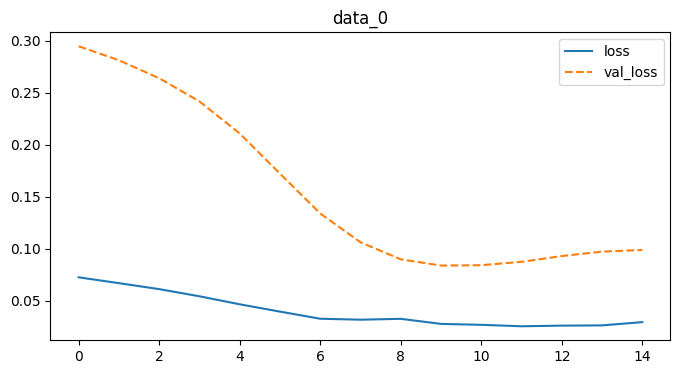

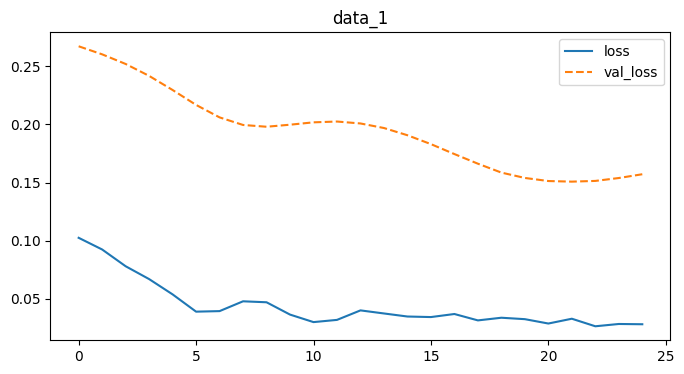

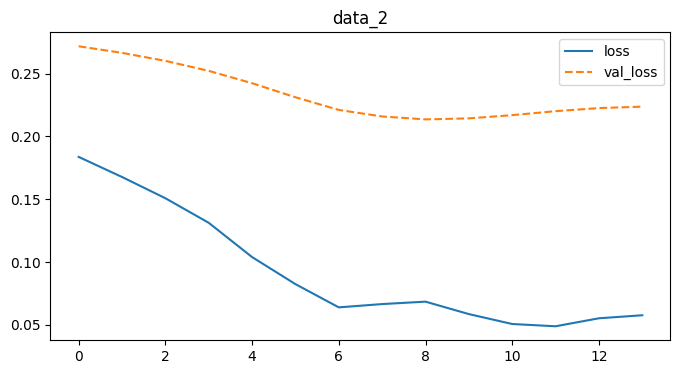

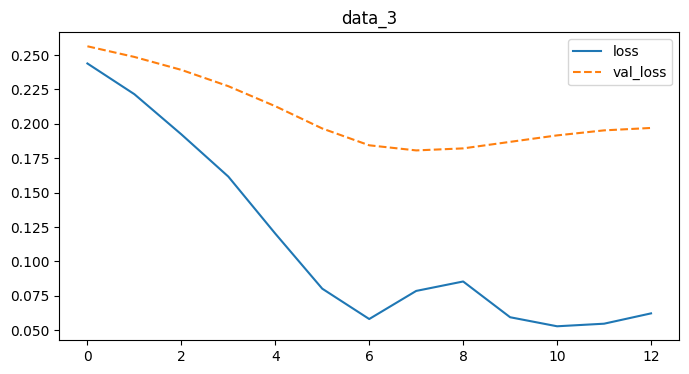

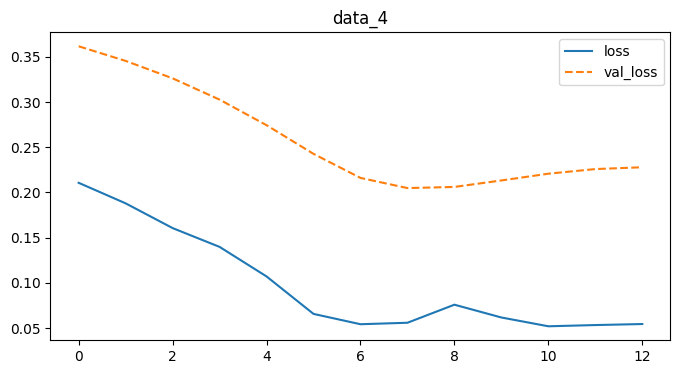

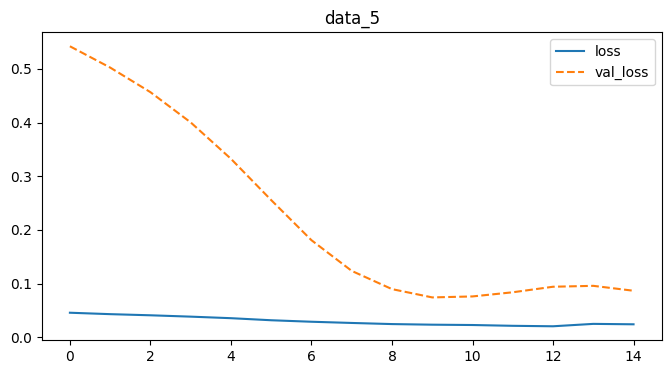

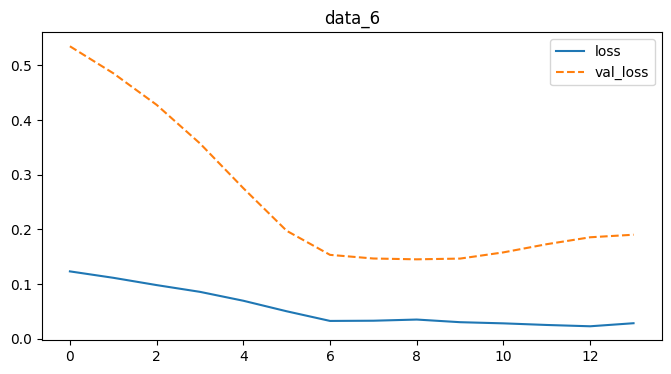

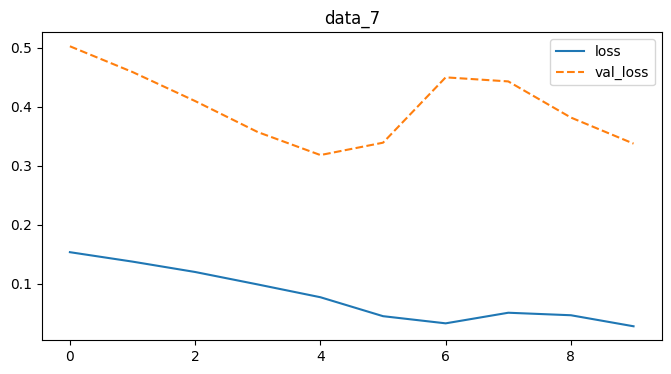

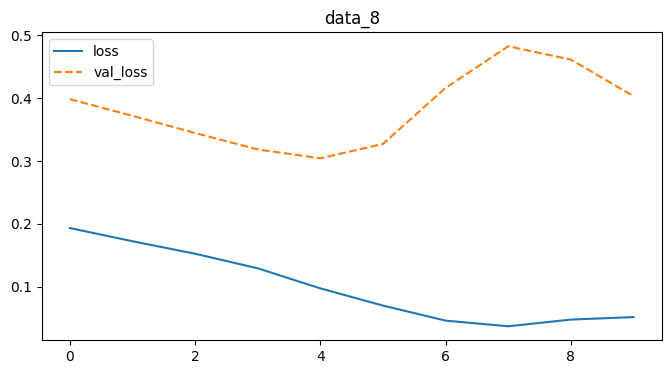

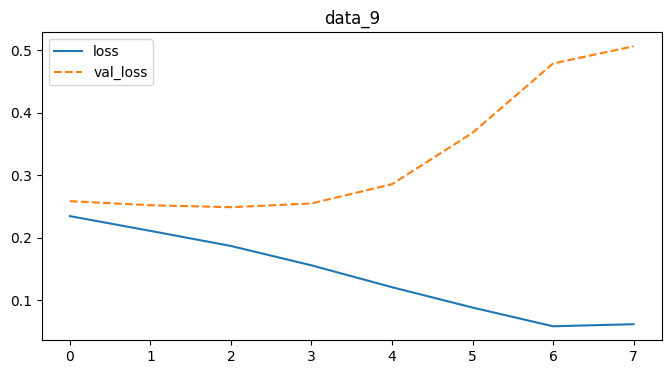

In [64]:
for i in history:
    # Loss
    fig, ax = plt.subplots(figsize=(8,4))
    plt.title('loss')
    plt.title(i)
    plt.plot(history[i].history['loss'], label='loss')
    plt.plot(history[i].history['val_loss'], label='val_loss', linestyle='--')
    plt.legend()
    plt.show()


In [43]:
def preprocessing_test_data_Lstm(train_data, test_data, base_day, prediction_day, slide):
    x_test = {}
    y_test = {}
    for i in test_data:
        scaler = MinMaxScaler(feature_range=(-1,1))
        model_inputs = pd.concat((train_data[i]['Close'].iloc[-base_day:], test_data[i]['Close'])).values
        model_inputs = model_inputs.reshape(-1,1)
        model_inputs = scaler.fit_transform(model_inputs)
        x_test[i] = []
        y_test[i] = []
        for x in range(base_day+prediction_day, len(model_inputs), slide):
            x_test[i].append(model_inputs[x-base_day-prediction_day:x-prediction_day])
            y_test[i].append(model_inputs[x-prediction_day:x])
        x_test[i], y_test[i] = np.array(x_test[i]), np.array(y_test[i])
        x_test[i] = np.reshape(x_test[i], (x_test[i].shape[0], x_test[i].shape[1], 1))
        y_test[i] = np.reshape(y_test[i], (y_test[i].shape[0], y_test[i].shape[1], 1))
    return x_test, y_test

In [44]:
x_test, y_test = preprocessing_test_data_Lstm(train_data, test_data, base_day, prediction_day, slide)

In [45]:
test_data['data_2']

,index,Open,High,Low,Close,Volume,Dividends,Stock Splits,peaks,valleys,pv
0,2020-01-31,3282.330078,3282.330078,3214.679932,3225.520020,4529700000,0.0,0.0,NaN,3225.52002,valley
1,2020-02-03,3235.659912,3268.439941,3235.659912,3248.919922,3760460000,0.0,0.0,NaN,NaN,NaN
2,2020-02-04,3280.610107,3306.919922,3280.610107,3297.590088,3996900000,0.0,0.0,NaN,NaN,NaN
3,2020-02-05,3324.909912,3337.580078,3313.750000,3334.689941,4121480000,0.0,0.0,NaN,NaN,NaN
4,2020-02-06,3344.919922,3347.959961,3334.389893,3345.780029,3887250000,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
245,2021-01-21,3857.459961,3861.449951,3845.050049,3853.070068,4501760000,0.0,0.0,NaN,NaN,NaN
246,2021-01-22,3844.239990,3852.310059,3830.409912,3841.469971,5110890000,0.0,0.0,NaN,NaN,NaN
247,2021-01-25,3851.679932,3859.229980,3797.159912,3855.360107,7000840000,0.0,0.0,3855.360107,NaN,peak
248,2021-01-26,3862.959961,3870.899902,3847.780029,3849.620117,6137500000,0.0,0.0,NaN,NaN,NaN


In [46]:
def predicting_creat_processed_signal_Lstm(x_test, test_data):
    processed_signal = {}
    for i in test_data:
        predicted_prices = model[i].predict(x_test[i])
        processed_signal[i] = {}
        processed_signal[i][0] = pd.DataFrame(
            {'Close': predicted_prices.flatten()}, index=test_data[i].index[:len(predicted_prices.flatten())])
    return processed_signal

In [47]:
processed_signal = predicting_creat_processed_signal_Lstm(x_test, test_data)

1/1 [==============================] - 1s 1s/step


In [48]:
processed_signal['data_0'][0]

,Close
0,0.250092
1,0.248253
2,0.231444
3,0.224864
4,0.235747
...,...
235,0.319400
236,0.239586
237,0.333306
238,0.356738


In [49]:
# 3. Build model
# harmonics, model = build_model(
    # train_data, n_harm_lower_limit, n_harm_upper_limit, pv_range, data_range)
# harmonics = data_to_harmonics_function(train_data, data_range)
# processed_signal_FFT = mix_harmonics_function(
#     harmonics, n_harm_lower_limit, n_harm_upper_limit)


In [50]:
# processed_signal = processed_signal_FFT

In [51]:
find_signal_pv_function(processed_signal, pv_range)
find_signal_lead_train_function(train_data, processed_signal)

In [52]:
# 4. Select model
# errors, best_fit_harm, best_error, first_date, lead, pv = select_model(test_data,
#                                                                         model, fit_method)
errors = get_fit_error_function(processed_signal, fit_method)
best_fit_harm, best_error = get_best_fit_harm_function(
    processed_signal, errors)
find_signal_lead_test_function(test_data, processed_signal)
first_date, lead, pv = get_first_lead_function(
    processed_signal, best_fit_harm)


In [53]:
test_data['data_9']

,index,Open,High,Low,Close,Volume,Dividends,Stock Splits,peaks,valleys,pv
0,2020-05-12,2939.500000,2945.820068,2869.590088,2870.120117,5119630000,0.0,0.0,NaN,NaN,NaN
1,2020-05-13,2865.860107,2874.139893,2793.149902,2820.000000,6151650000,0.0,0.0,NaN,2820.000000,valley
2,2020-05-14,2794.540039,2852.800049,2766.639893,2852.500000,5651130000,0.0,0.0,NaN,NaN,NaN
3,2020-05-15,2829.949951,2865.010010,2816.780029,2863.699951,5507700000,0.0,0.0,NaN,NaN,NaN
4,2020-05-18,2913.860107,2968.090088,2913.860107,2953.909912,6373670000,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
245,2021-05-03,4191.979980,4209.390137,4188.029785,4192.660156,4070220000,0.0,0.0,NaN,NaN,NaN
246,2021-05-04,4179.040039,4179.040039,4128.589844,4164.660156,4452460000,0.0,0.0,NaN,4164.660156,valley
247,2021-05-05,4177.060059,4187.720215,4160.939941,4167.589844,4230920000,0.0,0.0,NaN,NaN,NaN
248,2021-05-06,4169.140137,4202.700195,4147.330078,4201.620117,4511000000,0.0,0.0,NaN,NaN,NaN


In [54]:
result_table = built_result_table_function(
    processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm)

In [55]:
test_data['data_9']

,index,Open,High,Low,Close,Volume,Dividends,Stock Splits,peaks,valleys,pv
0,2020-05-12,2939.500000,2945.820068,2869.590088,2870.120117,5119630000,0.0,0.0,NaN,NaN,NaN
1,2020-05-13,2865.860107,2874.139893,2793.149902,2820.000000,6151650000,0.0,0.0,NaN,2820.000000,valley
2,2020-05-14,2794.540039,2852.800049,2766.639893,2852.500000,5651130000,0.0,0.0,NaN,NaN,NaN
3,2020-05-15,2829.949951,2865.010010,2816.780029,2863.699951,5507700000,0.0,0.0,NaN,NaN,NaN
4,2020-05-18,2913.860107,2968.090088,2913.860107,2953.909912,6373670000,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
245,2021-05-03,4191.979980,4209.390137,4188.029785,4192.660156,4070220000,0.0,0.0,NaN,NaN,NaN
246,2021-05-04,4179.040039,4179.040039,4128.589844,4164.660156,4452460000,0.0,0.0,NaN,4164.660156,valley
247,2021-05-05,4177.060059,4187.720215,4160.939941,4167.589844,4230920000,0.0,0.0,NaN,NaN,NaN
248,2021-05-06,4169.140137,4202.700195,4147.330078,4201.620117,4511000000,0.0,0.0,NaN,NaN,NaN


In [56]:
def result_table_process_Lstm_function(result_table, all_data, first_date, data_range):
    for i in result_table.index:
        t_date = all_data.iloc[all_data.index.get_loc(result_table.loc[i, 's_date']) + first_date[i]].name
        result_table.loc[i, 't_date'] = t_date
        ans = all_data.iloc[int(all_data.index.get_loc(t_date) + result_table.loc[i, 'lead'])].name
        result_table.loc[i, 'ans_date'] = ans

In [57]:
# 5. Evaluate model
# result_table, final_error = evaluate_model(
#     model, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range)
result_table = built_result_table_function(
    processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    print(result_table)

            s_date t_date  lead ans_date      pv error best_fit
data_0  2020-01-02    NaN  -5.0      NaN  valley  8.96        0
data_1  2020-01-16    NaN   2.0      NaN  valley   8.8        0
data_2  2020-01-31    NaN  10.0      NaN    peak  7.38        0
data_3  2020-02-14    NaN  -3.0      NaN    peak  8.72        0
data_4  2020-03-02    NaN  10.0      NaN  valley   7.5        0
data_5  2020-03-16    NaN   1.0      NaN    peak  8.45        0
data_6  2020-03-30    NaN  -5.0      NaN  valley  8.33        0
data_7  2020-04-14    NaN   6.0      NaN    peak  7.39        0
data_8  2020-04-28    NaN  -2.0      NaN  valley   8.0        0
data_9  2020-05-12    NaN  17.0      NaN    peak   6.3        0


In [58]:
result_table_process_Lstm_function(
    result_table, all_data, first_date, data_range)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    print(result_table)

            s_date      t_date  lead    ans_date      pv error best_fit
data_0  2020-01-02  2020-01-10  -5.0  2020-01-03  valley  8.96        0
data_1  2020-01-16  2020-01-29   2.0  2020-01-31  valley   8.8        0
data_2  2020-01-31  2020-02-04  10.0  2020-02-19    peak  7.38        0
data_3  2020-02-14  2020-02-24  -3.0  2020-02-19    peak  8.72        0
data_4  2020-03-02  2020-03-09  10.0  2020-03-23  valley   7.5        0
data_5  2020-03-16  2020-03-25   1.0  2020-03-26    peak  8.45        0
data_6  2020-03-30  2020-04-08  -5.0  2020-04-01  valley  8.33        0
data_7  2020-04-14  2020-04-21   6.0  2020-04-29    peak  7.39        0
data_8  2020-04-28  2020-05-05  -2.0  2020-05-01  valley   8.0        0
data_9  2020-05-12  2020-05-13  17.0  2020-06-08    peak   6.3        0


In [59]:
final_error = compute_final_error_function(result_table)
print('final_error = ', final_error)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    print(result_table)

final_error =  6.1
            s_date      t_date  lead    ans_date      pv error best_fit
data_0  2020-01-02  2020-01-10  -5.0  2020-01-03  valley  8.96        0
data_1  2020-01-16  2020-01-29   2.0  2020-01-31  valley   8.8        0
data_2  2020-01-31  2020-02-04  10.0  2020-02-19    peak  7.38        0
data_3  2020-02-14  2020-02-24  -3.0  2020-02-19    peak  8.72        0
data_4  2020-03-02  2020-03-09  10.0  2020-03-23  valley   7.5        0
data_5  2020-03-16  2020-03-25   1.0  2020-03-26    peak  8.45        0
data_6  2020-03-30  2020-04-08  -5.0  2020-04-01  valley  8.33        0
data_7  2020-04-14  2020-04-21   6.0  2020-04-29    peak  7.39        0
data_8  2020-04-28  2020-05-05  -2.0  2020-05-01  valley   8.0        0
data_9  2020-05-12  2020-05-13  17.0  2020-06-08    peak   6.3        0


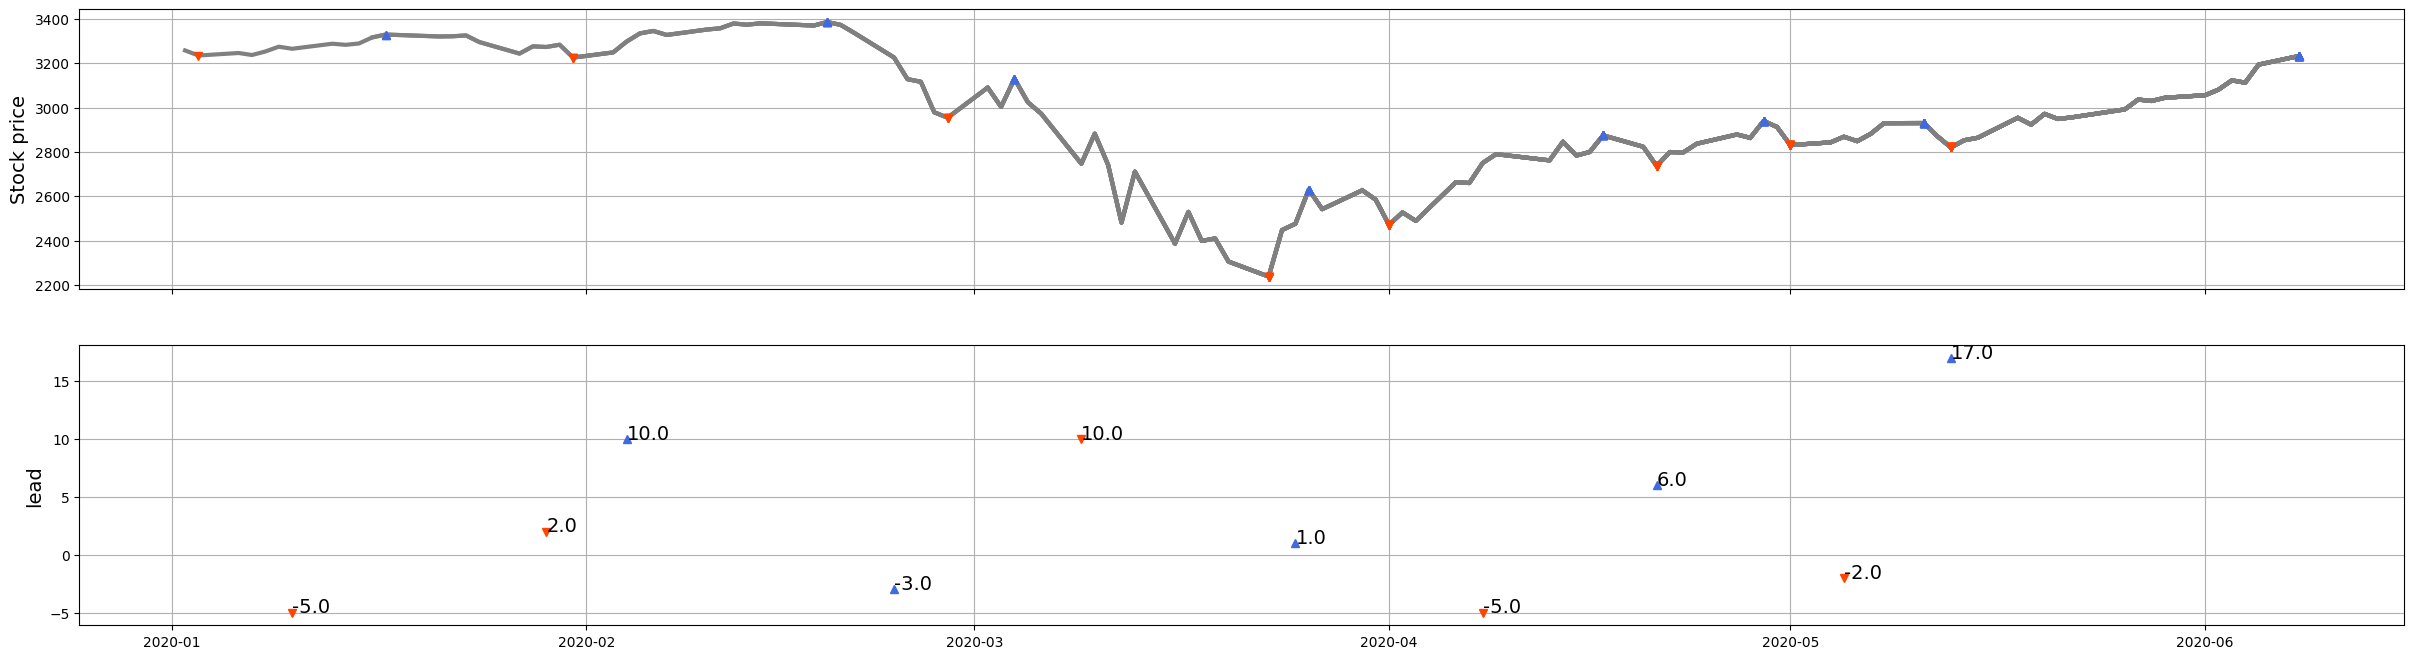

In [60]:
draw_plot_result_table(test_data, all_data, result_table, pv_range)

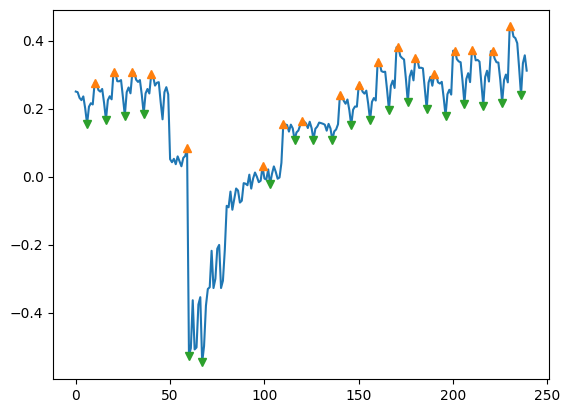

In [61]:
plt.plot(processed_signal['data_0'][0]['Close'])
plt.plot(processed_signal['data_0'][0]['peaks'], '^')
plt.plot(processed_signal['data_0'][0]['valleys'], 'v')

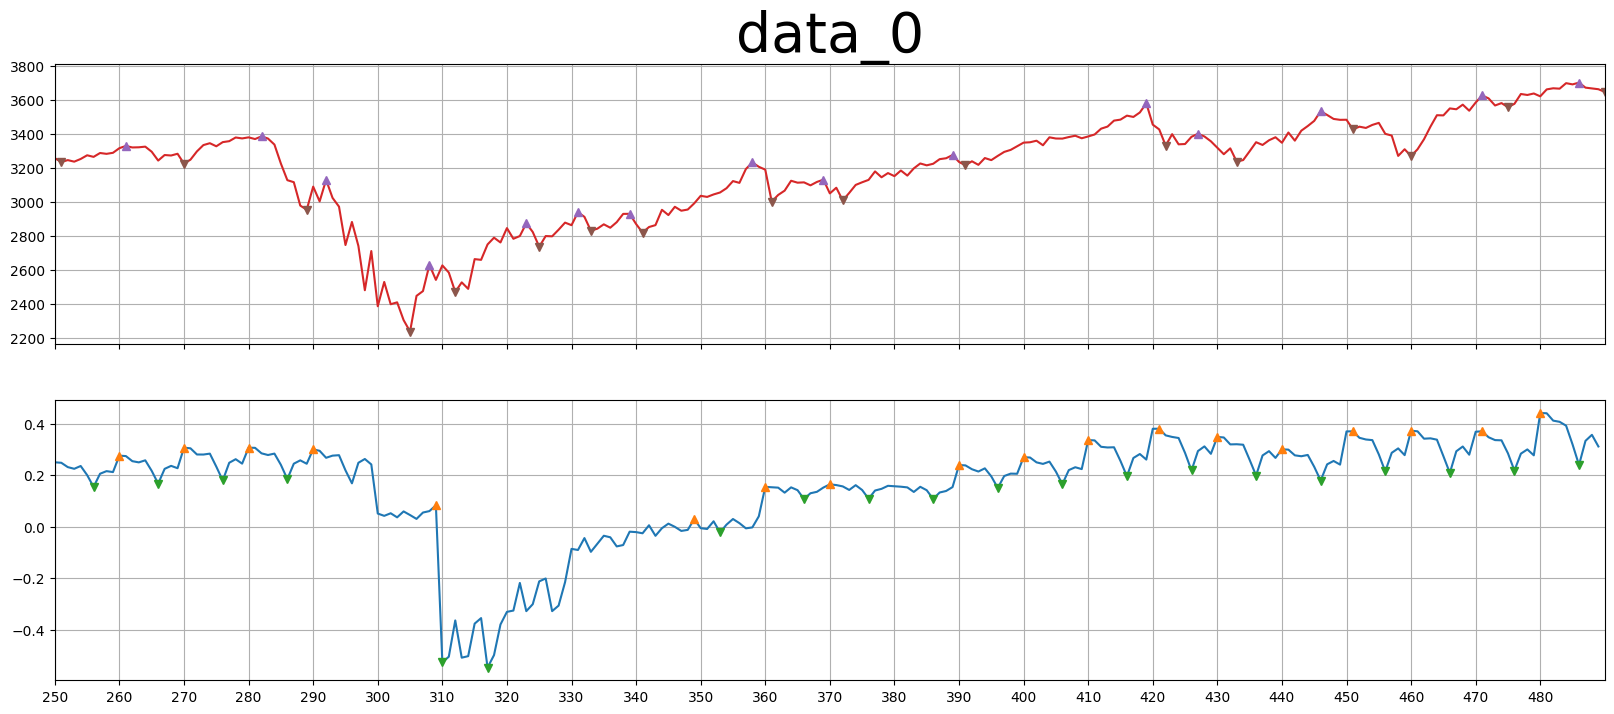

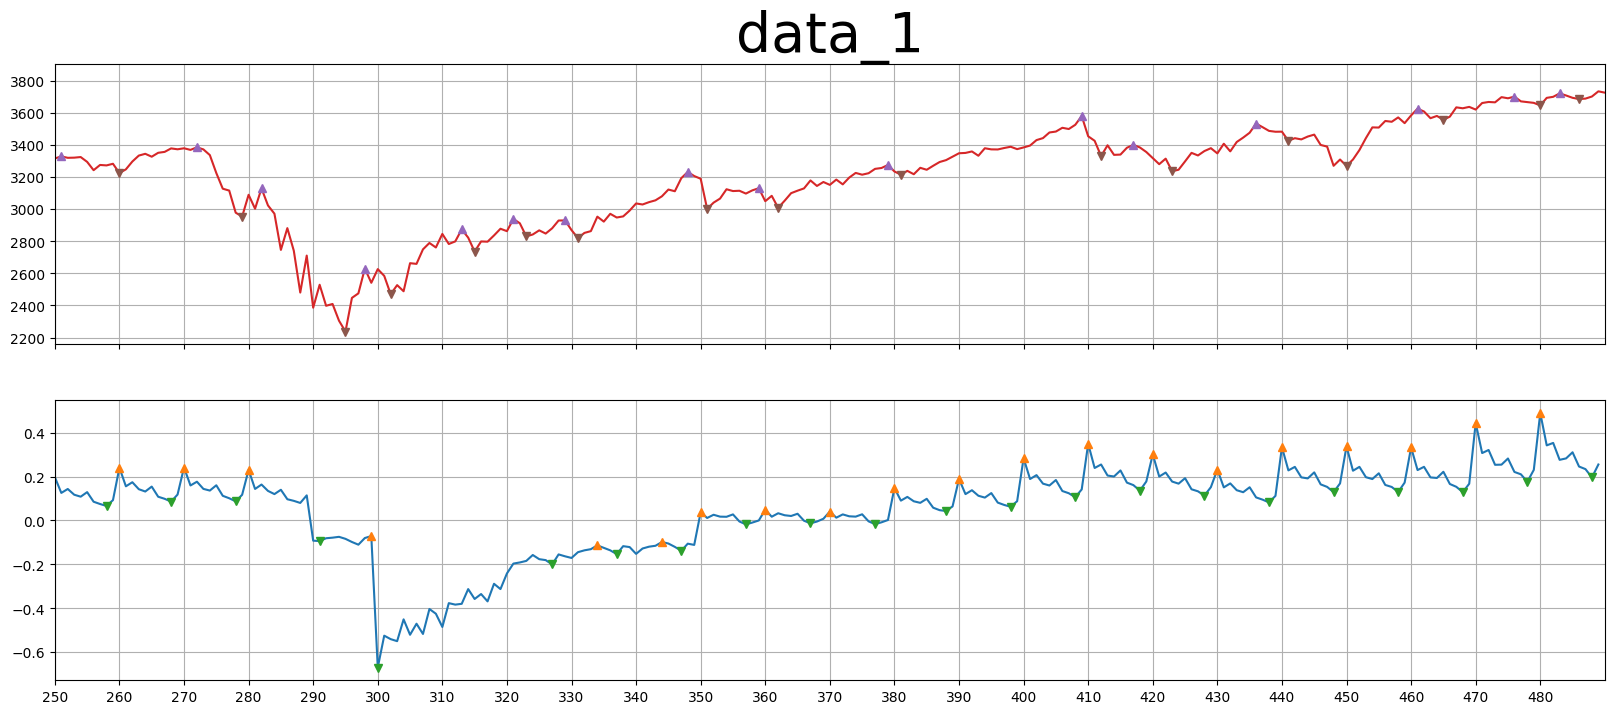

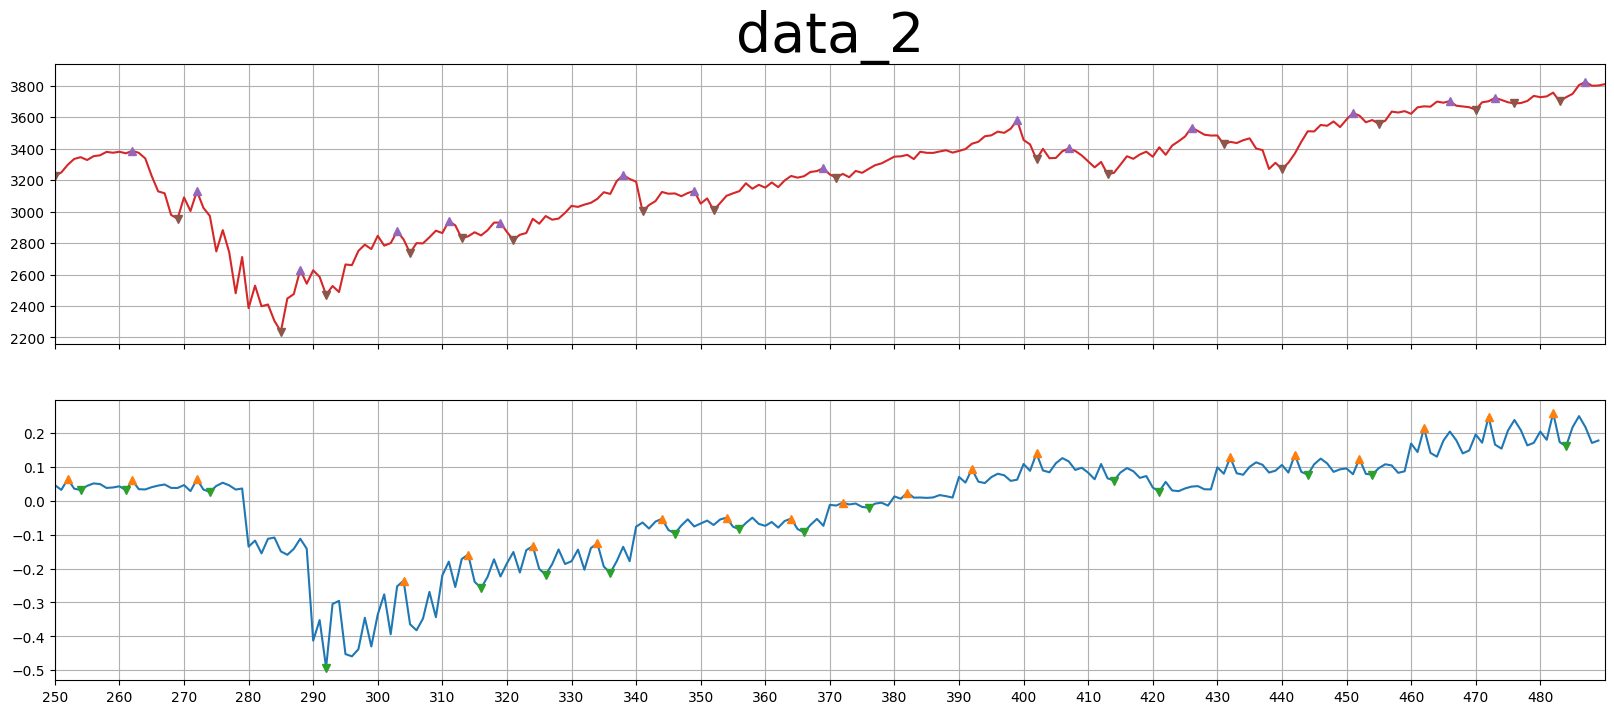

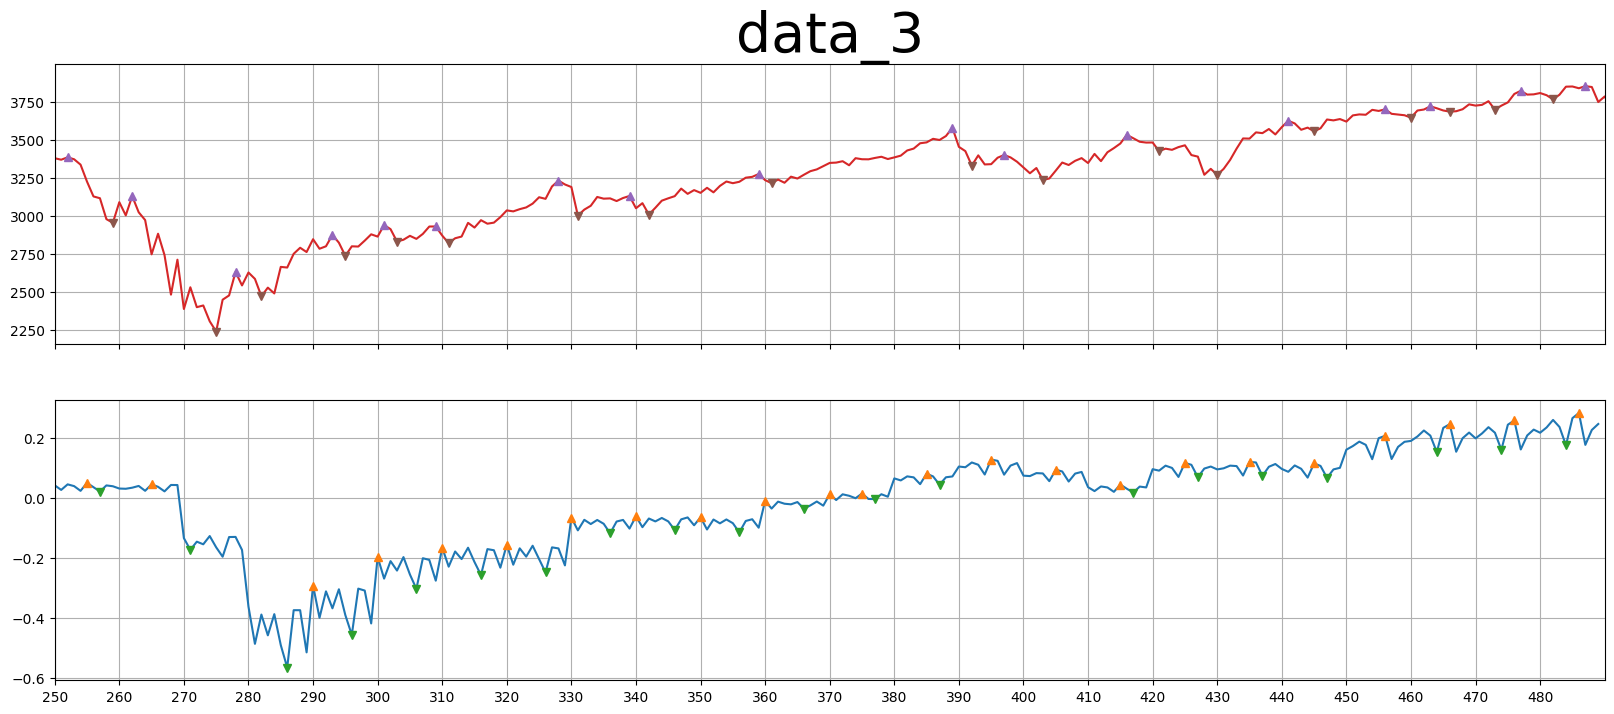

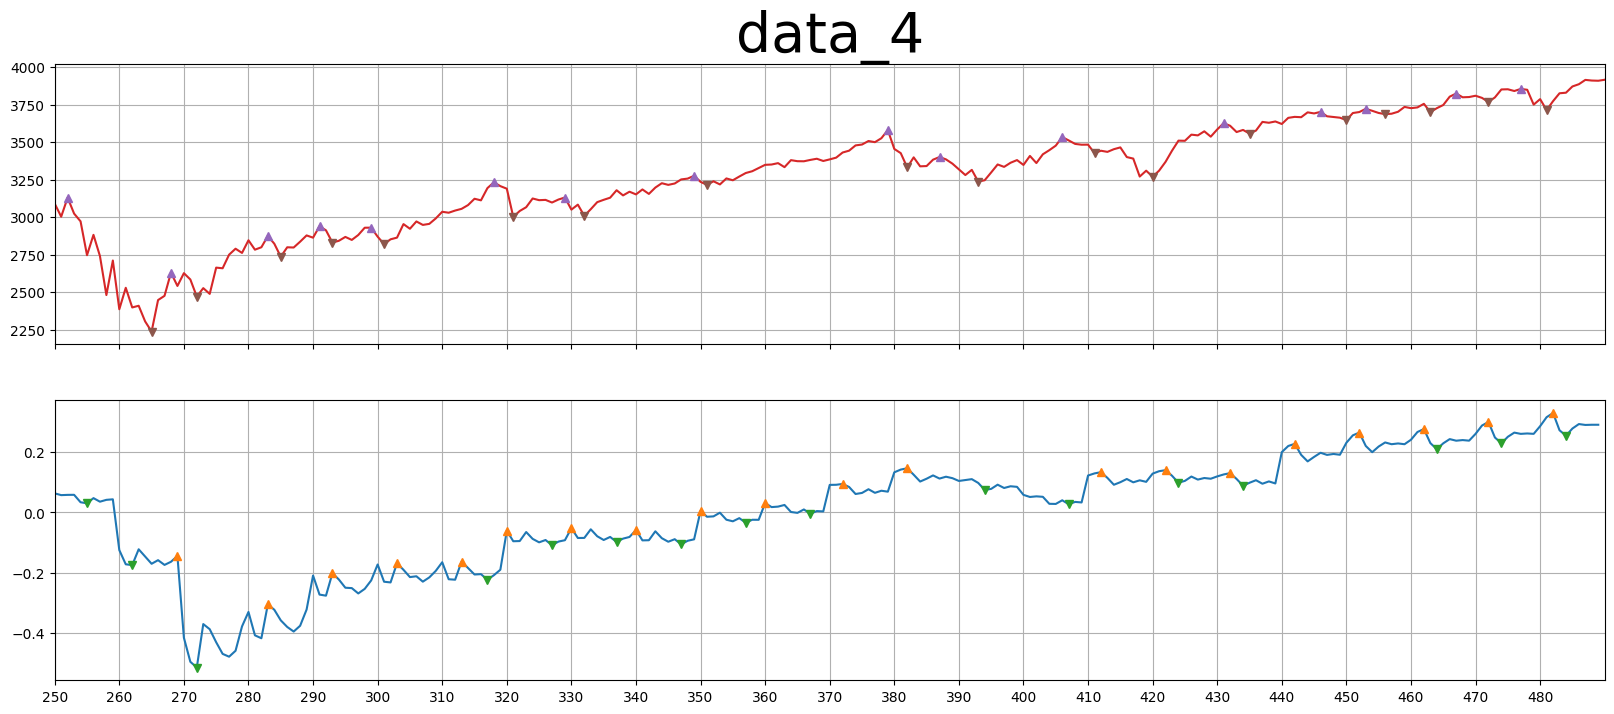

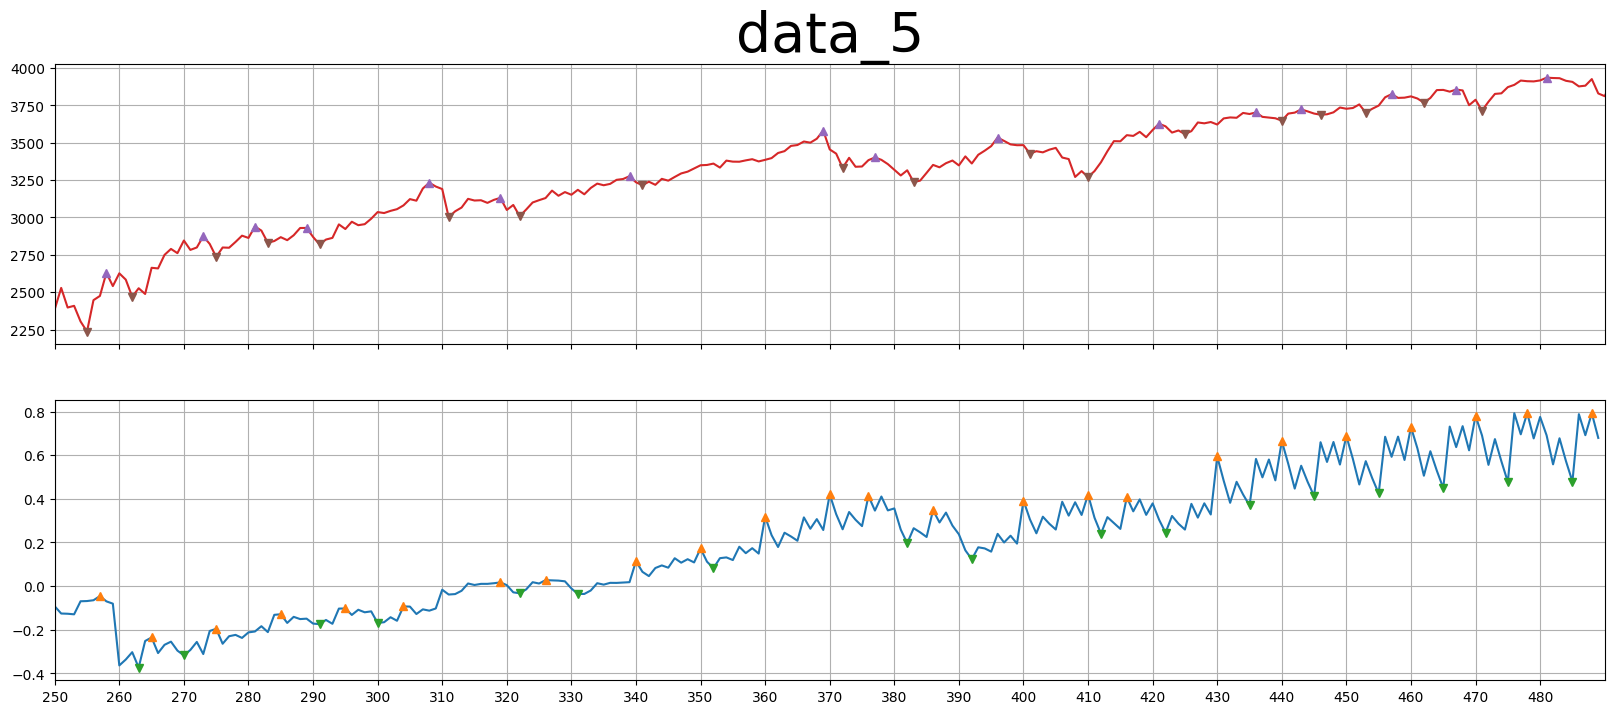

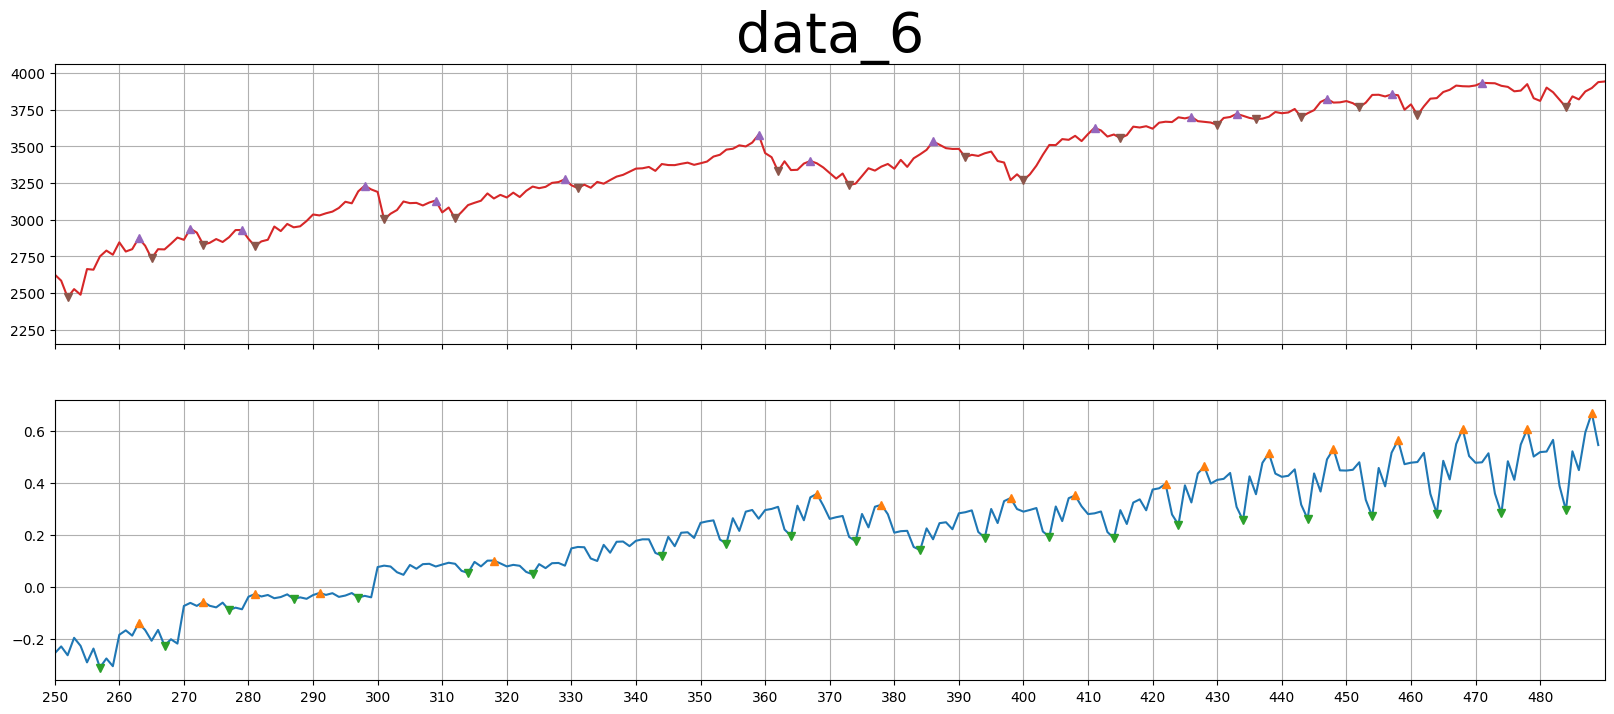

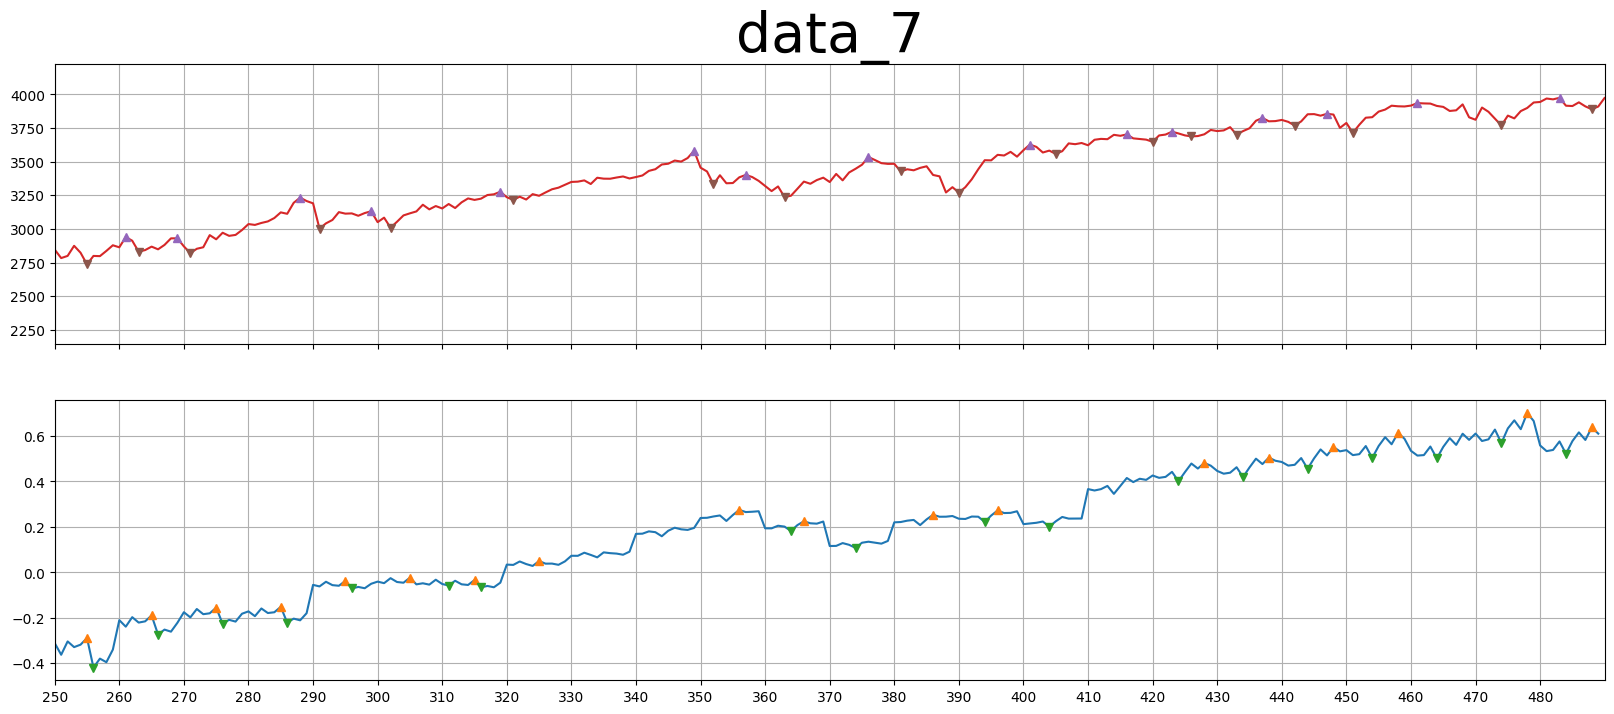

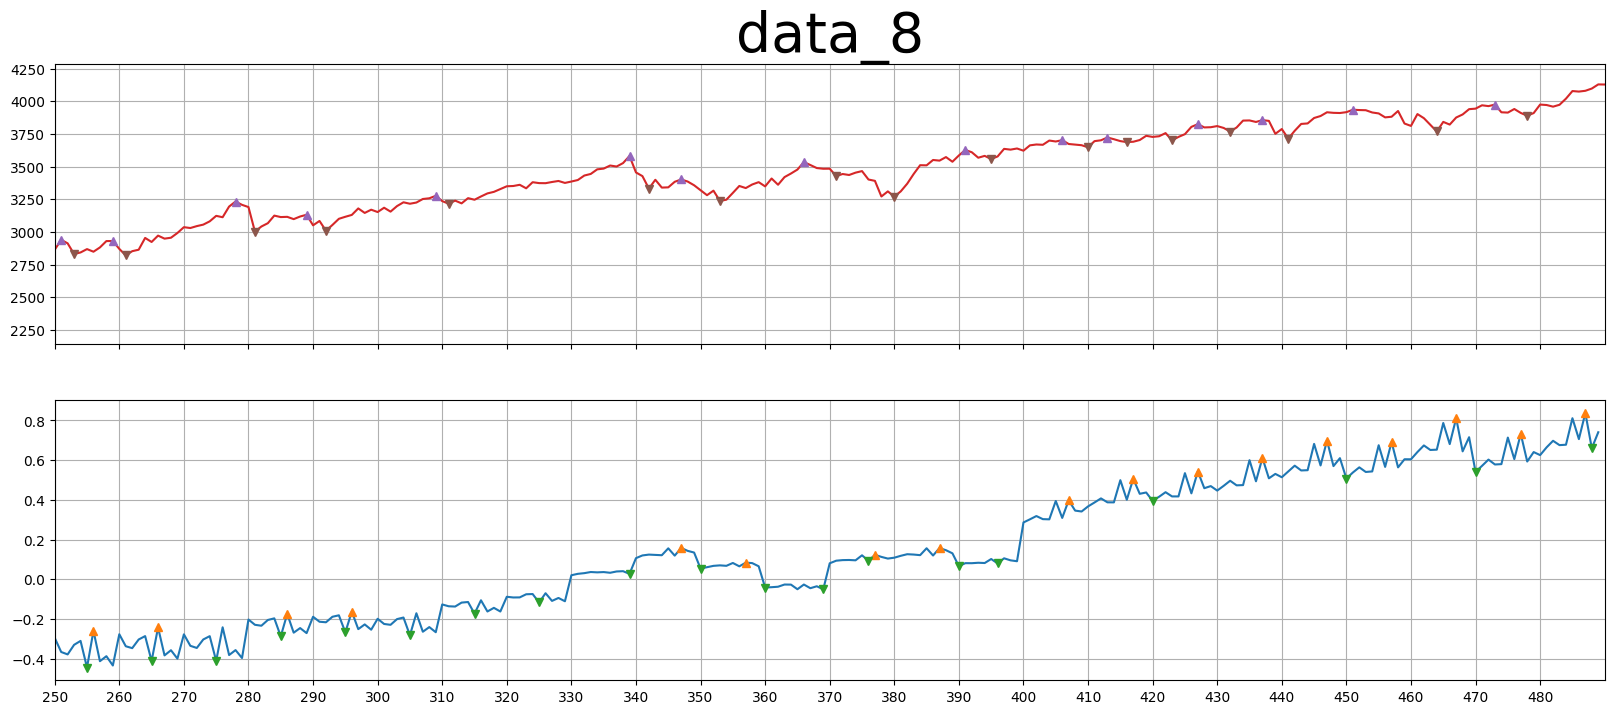

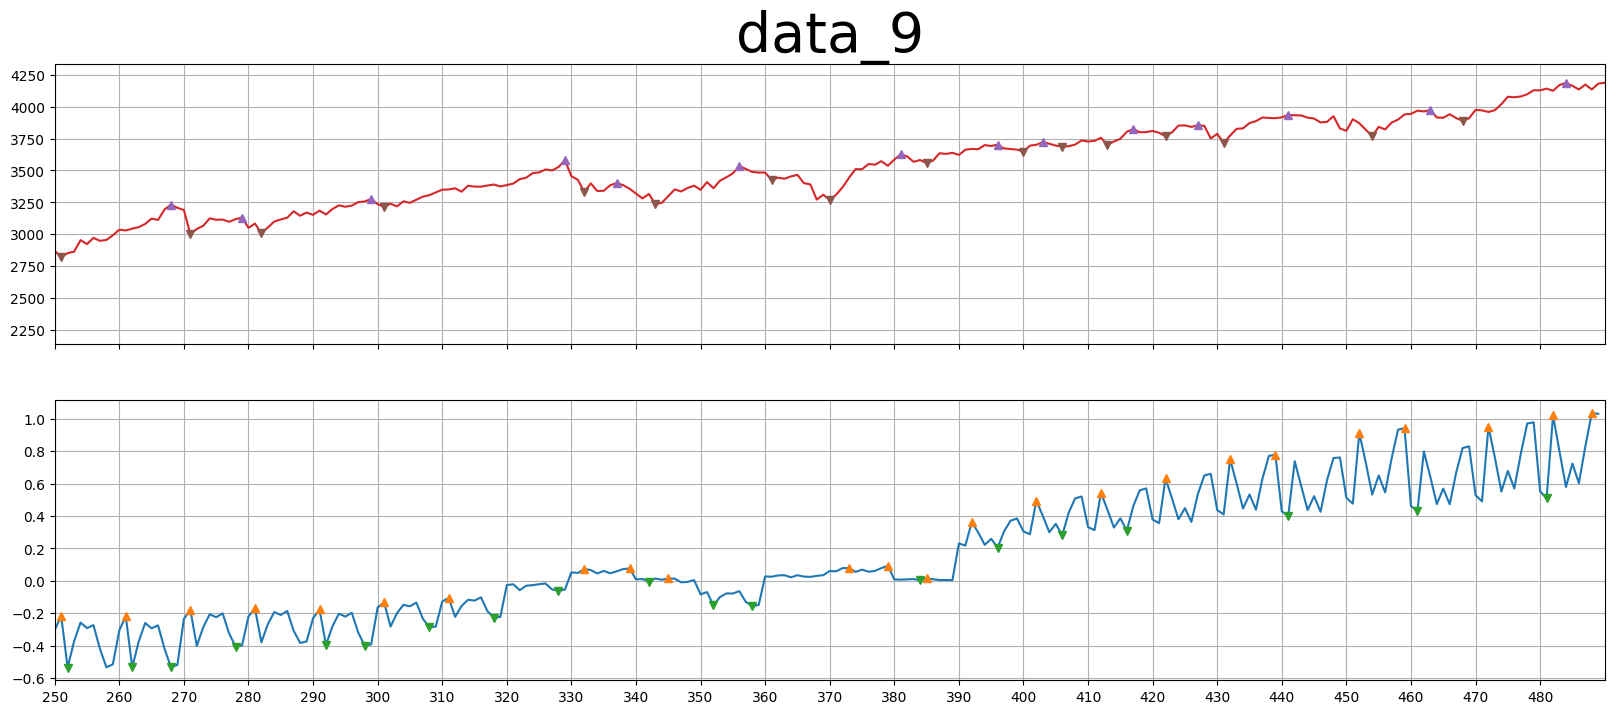

In [62]:
for i in processed_signal:
    fig, axes = plt.subplots(2, 1, figsize=(20, 8), sharex=True)
    axes[0].set_title(i, fontsize=40)
    axes[0].plot(range(0, len(train_data[i])), train_data[i]['Close'])
    axes[0].plot(range(0, len(train_data[i])), train_data[i]['peaks'], '^')
    axes[0].plot(range(0, len(train_data[i])), train_data[i]['valleys'], 'v')
    axes[0].plot(range(len(train_data[i]), len(test_data[i])+len(train_data[i])), test_data[i]['Close'])
    axes[0].plot(range(len(train_data[i]), len(test_data[i])+len(train_data[i])), test_data[i]['peaks'], '^')
    axes[0].plot(range(len(train_data[i]), len(test_data[i])+len(train_data[i])), test_data[i]['valleys'], 'v')
    axes[1].plot(range(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]])), processed_signal[i][best_fit_harm[i]]['Close'])
    axes[1].plot(range(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]])), processed_signal[i][best_fit_harm[i]]['peaks'], '^')
    axes[1].plot(range(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]])), processed_signal[i][best_fit_harm[i]]['valleys'], 'v')
    plt.xlim(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]]))
    axes[0].grid()
    axes[1].grid()
    plt.xticks(np.arange(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]]), step=10))
    plt.show()